In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
print("pytorch ver . ",torch.__version__)
print("Is CUDA available?",torch.cuda.is_available())
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.utils.data as Data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import xarray as xr
import os
os.environ['R_HOME'] = '/home/luhung3080/miniconda3/envs/chou/lib/R'
from rpy2.robjects import r, numpy2ri
numpy2ri.activate()
from rpy2.robjects.packages import importr
sinkr = importr('sinkr')
import Nio
print ("pynio ver . ",Nio.__version__)

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pytorch ver .  1.11.0+cu113
Is CUDA available? True
pynio ver .  1.5.5


In [2]:
data=pd.read_csv('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/data_final.csv')
data

,SITE_ID,date,FCST_TIME,TAU,pm25_cal,pm25_obs
0,EPA001,2020-02-24 08:00:00,2020-02-24 09:00:00,1,4.9510,10.0
1,EPA001,2020-02-24 08:00:00,2020-02-24 10:00:00,2,4.4674,13.0
2,EPA001,2020-02-24 08:00:00,2020-02-24 11:00:00,3,4.6159,11.0
3,EPA001,2020-02-24 08:00:00,2020-02-24 12:00:00,4,3.9937,11.0
4,EPA001,2020-02-24 08:00:00,2020-02-24 13:00:00,5,3.9602,9.0
...,...,...,...,...,...,...
3092755,EPA080,2021-10-30 08:00:00,2021-11-02 04:00:00,68,3.6190,4.0
3092756,EPA080,2021-10-30 08:00:00,2021-11-02 05:00:00,69,3.7908,7.0
3092757,EPA080,2021-10-30 08:00:00,2021-11-02 06:00:00,70,4.0454,7.0
3092758,EPA080,2021-10-30 08:00:00,2021-11-02 07:00:00,71,3.9015,4.0


In [3]:
x1=np.zeros([604,1704])
x2=np.zeros([604,5112])

#x1 (0th~1703th column as x)
for i in range (0,604):
    for j in range (0,71):
        a=np.array(data['pm25_obs'][5112*i+72*j:5112*i+72*j+24])
        for k in range (0,24):
            x1[i][j*24+k]=a[k]

#x2 (1704th~8519th column as x)
for i in range (1,604):
    b=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    for j in range(0,5112):
        x2[i-1][j]=b[j]
        
print(np.shape(x1))
print(np.shape(x2))

(604, 1704)
(604, 5112)


In [4]:
x1Restruct_Fun=x1
x2Restruct_Fun=x2
print(np.shape(x1Restruct_Fun))
print(np.shape(x2Restruct_Fun))

(604, 1704)
(604, 5112)


In [5]:
YRestruct_Fun=np.zeros([601,5112])
for j in range (0,71):
    for i in range(0,601):
        YRestruct_Fun[i][72*j:72*j+24]=x1Restruct_Fun[1+i][24*j:24*j+24]
        YRestruct_Fun[i][72*j+24:72*j+48]=x1Restruct_Fun[1+i+1][24*j:24*j+24]
        YRestruct_Fun[i][72*j+48:72*j+72]=x1Restruct_Fun[1+i+2][24*j:24*j+24]
print(np.shape(YRestruct_Fun))

(601, 5112)


In [6]:
XRestruct_Fun=np.zeros([601,6816])
for i in range (0,601):
    for j in range (0,1704):
        XRestruct_Fun[i][j]=x1Restruct_Fun[i][j]
    for j in range (1704,6816):
        XRestruct_Fun[i][j]=x2Restruct_Fun[i][j-1704]
print(np.shape(XRestruct_Fun))

(601, 6816)


In [9]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
X1hat_train = np.zeros([540,1704])
X2hat_train = np.zeros([540,5112])
Yhat_train = np.zeros([540,5112])
X1hat_test = np.zeros([61,1704])
X2hat_test = np.zeros([61,5112])
Yhat_test = np.zeros([61,5112])
for i in range (0,540):
    for j in range (0,1704):
        X1hat_train[i][j] = Xhat[i][j]
    for j in range (1704,6816):
        X2hat_train[i][j-1704] = Xhat[i][j]
    for j in range (0,5112):
        Yhat_train[i][j] = Yhat[i][j]
for i in range (540,601):
    for j in range (0,1704):
        X1hat_test[i-540][j] = Xhat[i][j]    
    for j in range (1704,6816):
        X2hat_test[i-540][j-1704] = Xhat[i][j]
    for j in range (0,5112):     
        Yhat_test[i-540][j] = Yhat[i][j]

In [10]:
print('X1hat_train')
#print(X1hat_train)
print(np.shape(X1hat_train))
print('X2hat_train')
#print(X2hat_train)
print(np.shape(X2hat_train))
print('Yhat_train')
#print(Yhat_train)
print(np.shape(Yhat_train))
print('X1hat_test')
#print(X1hat_test)
print(np.shape(X1hat_test))
print('X2hat_test')
#print(X2hat_test)
print(np.shape(X2hat_test))
print('Yhat_test')
#print(Yhat_test)
print(np.shape(Yhat_test))

X1hat_train
(540, 1704)
X2hat_train
(540, 5112)
Yhat_train
(540, 5112)
X1hat_test
(61, 1704)
X2hat_test
(61, 5112)
Yhat_test
(61, 5112)


# GD

In [21]:
x1 = X1hat_train
x2 = X2hat_train
y = Yhat_train
xt1 = X1hat_test
xt2 = X2hat_test
yt = Yhat_test

In [17]:
def model (x1,x2,b0,b1,b2):
    y = b0 +  torch.matmul(x1,b1) + torch.matmul(x2,b2)
#    y = b0 +  b1*x1 + torch.matmul(x2,b2)
    return y

In [18]:
features1 = torch.from_numpy(x1)
features2 = torch.from_numpy(x2)
targets = torch.from_numpy(y)
x_test1 = torch.from_numpy(xt1)
x_test2 = torch.from_numpy(xt2)
y_test = torch.from_numpy(yt)


beta0 = torch.ones(5112 , requires_grad = True)
beta1 = torch.ones([1704,5112], requires_grad = True)
#beta1 = torch.ones(5112, requires_grad = True)
beta2 = torch.ones([5112,5112], requires_grad = True)

rate = 1e-3
optimizer = optim.Adam([beta0 , beta1 , beta2], lr=rate)

epo = 2001
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features1.float() , features2.float(), beta0 , beta1 , beta2)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test1.float(), x_test2.float() , beta0, beta1 , beta2) 
#     for i in range (25):
#         for j in range (6816):
#             if y_test[i][j] == 0:
#                 yhats_test[i][j] = 0
    r = torch.abs(yhats_test - y_test)
    test_loss = torch.mean(r)
    # test_loss = loss(y_test , yhats_test)
    test_error[epoch] = test_loss

    if epoch <= 10 or epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                    f" Testing loss {test_loss.item():.4f}")
        # print('\tBeta_0 : ' , beta0)
        # print('\tBeta_1 : ' , beta1)
        # print('\tBeta_2 : ' , beta2)       
    else :
        if epoch >= epo-10 :
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                        f" Testing loss {test_loss.item():.4f}")
            # print('\tBeta_0 : ' , beta0)
            # print('\tBeta_1 : ' , beta1)
            # print('\tBeta_2 : ' , beta2) 

Epoch 0, Training loss 94251.3672, Testing loss 99211.3229
Epoch 1, Training loss 94157.1016, Testing loss 99112.0035
Epoch 2, Training loss 94062.8438, Testing loss 99012.6836
Epoch 3, Training loss 93968.5703, Testing loss 98913.3581
Epoch 4, Training loss 93874.3125, Testing loss 98814.0281
Epoch 5, Training loss 93780.0391, Testing loss 98714.7157
Epoch 6, Training loss 93685.7812, Testing loss 98615.4018
Epoch 7, Training loss 93591.5312, Testing loss 98516.0701
Epoch 8, Training loss 93497.2500, Testing loss 98416.7487
Epoch 9, Training loss 93402.9844, Testing loss 98317.4209
Epoch 10, Training loss 93308.7188, Testing loss 98218.1048
Epoch 20, Training loss 92366.0625, Testing loss 97224.9121
Epoch 30, Training loss 91423.4141, Testing loss 96231.6494
Epoch 40, Training loss 90480.7656, Testing loss 95238.4402
Epoch 50, Training loss 89538.1016, Testing loss 94245.2122
Epoch 60, Training loss 88595.4609, Testing loss 93251.9930
Epoch 70, Training loss 87652.8125, Testing loss 9

Epoch 1300, Training loss 4.6463, Testing loss 6.5533
Epoch 1310, Training loss 4.7598, Testing loss 6.7171
Epoch 1320, Training loss 4.9274, Testing loss 6.8070
Epoch 1330, Training loss 4.9417, Testing loss 6.8947
Epoch 1340, Training loss 5.1124, Testing loss 6.9655
Epoch 1350, Training loss 5.2051, Testing loss 7.1257
Epoch 1360, Training loss 5.2191, Testing loss 7.1722
Epoch 1370, Training loss 5.3030, Testing loss 7.2666
Epoch 1380, Training loss 5.4309, Testing loss 7.3878
Epoch 1390, Training loss 5.3960, Testing loss 7.3938
Epoch 1400, Training loss 5.4279, Testing loss 7.3925
Epoch 1410, Training loss 5.5086, Testing loss 7.4695
Epoch 1420, Training loss 5.5795, Testing loss 7.5880
Epoch 1430, Training loss 5.6629, Testing loss 7.5991
Epoch 1440, Training loss 5.6940, Testing loss 7.6627
Epoch 1450, Training loss 5.6699, Testing loss 7.7053
Epoch 1460, Training loss 5.7150, Testing loss 7.7440
Epoch 1470, Training loss 5.7346, Testing loss 7.7366
Epoch 1480, Training loss 5.

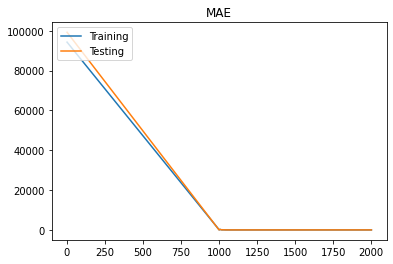

In [19]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,train_error, label = 'Training')
plt.plot(x,test_error, label ='Testing')
plt.legend(loc = 2)
plt.title('MAE')

plt.show()

In [20]:
print(np.min(test_error))

4.976625332326482


In [22]:
def model (x1,x2,b0,b1,b2):
    y = b0 +  torch.matmul(x1,b1) + b2*x2
    return y
features1 = torch.from_numpy(x1)
features2 = torch.from_numpy(x2)
targets = torch.from_numpy(y)
x_test1 = torch.from_numpy(xt1)
x_test2 = torch.from_numpy(xt2)
y_test = torch.from_numpy(yt)


beta0 = torch.ones(5112 , requires_grad = True)
beta1 = torch.ones([1704,5112], requires_grad = True)
#beta1 = torch.ones(5112, requires_grad = True)
beta2 = torch.ones(5112, requires_grad = True)

rate = 1e-3
optimizer = optim.Adam([beta0 , beta1 , beta2], lr=rate)

epo = 2001
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features1.float() , features2.float(), beta0 , beta1 , beta2)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test1.float(), x_test2.float() , beta0, beta1 , beta2) 
#     for i in range (25):
#         for j in range (6816):
#             if y_test[i][j] == 0:
#                 yhats_test[i][j] = 0
    r = torch.abs(yhats_test - y_test)
    test_loss = torch.mean(r)
    # test_loss = loss(y_test , yhats_test)
    test_error[epoch] = test_loss

    if epoch <= 10 or epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                    f" Testing loss {test_loss.item():.4f}")
        # print('\tBeta_0 : ' , beta0)
        # print('\tBeta_1 : ' , beta1)
        # print('\tBeta_2 : ' , beta2)       
    else :
        if epoch >= epo-10 :
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                        f" Testing loss {test_loss.item():.4f}")
            # print('\tBeta_0 : ' , beta0)
            # print('\tBeta_1 : ' , beta1)
            # print('\tBeta_2 : ' , beta2) 

Epoch 0, Training loss 25784.9043, Testing loss 21701.8924
Epoch 1, Training loss 25759.1074, Testing loss 21680.1584
Epoch 2, Training loss 25733.3066, Testing loss 21658.4242
Epoch 3, Training loss 25707.5078, Testing loss 21636.6838
Epoch 4, Training loss 25681.7070, Testing loss 21614.9415
Epoch 5, Training loss 25655.9004, Testing loss 21593.2138
Epoch 6, Training loss 25630.1035, Testing loss 21571.4877
Epoch 7, Training loss 25604.3184, Testing loss 21549.7405
Epoch 8, Training loss 25578.5078, Testing loss 21528.0057
Epoch 9, Training loss 25552.7090, Testing loss 21506.2626
Epoch 10, Training loss 25526.9082, Testing loss 21484.5337
Epoch 20, Training loss 25268.9102, Testing loss 21267.2015
Epoch 30, Training loss 25010.9141, Testing loss 21049.7978
Epoch 40, Training loss 24752.9199, Testing loss 20832.4496
Epoch 50, Training loss 24494.9141, Testing loss 20615.0810
Epoch 60, Training loss 24236.9258, Testing loss 20397.7238
Epoch 70, Training loss 23978.9336, Testing loss 2

Epoch 1310, Training loss 4.5261, Testing loss 5.3174
Epoch 1320, Training loss 4.4909, Testing loss 5.3167
Epoch 1330, Training loss 4.4571, Testing loss 5.3148
Epoch 1340, Training loss 4.4237, Testing loss 5.3128
Epoch 1350, Training loss 4.3912, Testing loss 5.3141
Epoch 1360, Training loss 4.3585, Testing loss 5.3107
Epoch 1370, Training loss 4.3267, Testing loss 5.3116
Epoch 1380, Training loss 4.2958, Testing loss 5.3090
Epoch 1390, Training loss 4.2647, Testing loss 5.3096
Epoch 1400, Training loss 4.2351, Testing loss 5.3083
Epoch 1410, Training loss 4.2050, Testing loss 5.3087
Epoch 1420, Training loss 4.1767, Testing loss 5.3073
Epoch 1430, Training loss 4.1483, Testing loss 5.3081
Epoch 1440, Training loss 4.1208, Testing loss 5.3077
Epoch 1450, Training loss 4.0926, Testing loss 5.3082
Epoch 1460, Training loss 4.0639, Testing loss 5.3092
Epoch 1470, Training loss 4.0377, Testing loss 5.3086
Epoch 1480, Training loss 4.0111, Testing loss 5.3083
Epoch 1490, Training loss 3.

In [23]:
print(np.min(test_error))

5.305869442905403


# LBFGS

In [ ]:
x1 = X1hat_train
x2 = X2hat_train
y = Yhat_train
xt1 = X1hat_test
xt2 = X2hat_test
yt = Yhat_test

In [ ]:
def model (x1,x2,b0,b1,b2):
    y = b0 +  torch.matmul(x1,b1) + torch.matmul(x2,b2)
    return y

In [ ]:
features1 = torch.from_numpy(x1)
features2 = torch.from_numpy(x2)
targets = torch.from_numpy(y)
x_test1 = torch.from_numpy(xt1)
x_test2 = torch.from_numpy(xt2)
y_test = torch.from_numpy(yt)

beta0 = torch.ones(5112 , requires_grad = True)
beta1 = torch.ones([1704,5112], requires_grad = True)
beta2 = torch.ones([5112,5112] , requires_grad = True)

# rate = 1
rate = 1e-2
optimizer = optim.LBFGS([beta0 , beta1 , beta2] , lr=rate)
# optimizer = optim.Adam([beta0 , beta1 , beta2], lr=rate)
# optimizer = optim.SGD([beta0 , beta1 , beta2], lr=rate)

epo = 201
loss = nn.MSELoss()
train_error = np.zeros(epo)
test_error = np.zeros(epo)

for epoch in range (epo):
    # yhats_train = model(features.float() , beta0 , beta1)
    # train_loss = loss(targets.float() , yhats_train)
    # train_error[epoch] = train_loss

    # optimizer.zero_grad()
    # if epoch == 0 :
    #         train_loss.backward(retain_graph=True) 
    # else :
    #     train_loss.backward()
    # # train_loss.backward() 
    # optimizer.step()    

    def closure():
        yhats_train = model(features1.float() , features2.float(), beta0 , beta1 , beta2)
        train_loss = loss(targets.float() , yhats_train)
        train_error[epoch] = train_loss
        optimizer.zero_grad()
        # if epoch == epo-1 :
        #     train_loss.backward() 
        # else :
        #     train_loss.backward(retain_graph=True)
        train_loss.backward(retain_graph=True)
        return train_loss
    optimizer.step(closure)    

    yhats_test = model(x_test1.float(), x_test2.float() , beta0, beta1 , beta2) 
#     for i in range (25):
#         for j in range (6816):
#             if y_test[i][j] == 0:
#                 yhats_test[i][j] = 0
    r = torch.abs(yhats_test - y_test)
    test_loss = torch.mean(r)
    test_error[epoch] = test_loss

    if epoch <= 10 or epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss {train_error[epoch]:.4f},"
                    f" Testing loss {test_error[epoch]:.4f}")
        # print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
        #             f" Testing loss {test_loss.item():.4f}")

        # print('\tBeta_0 : ' , beta0)
        # print('\tBeta_1 : ' , beta1)
        # print('\tBeta_2 : ' , beta2)       
    else :
        if epoch >= epo-10 :
            print(f"Epoch {epoch}, Training loss {train_error[epoch]:.4f},"
                        f" Testing loss {test_error[epoch]:.4f}")
            # print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
            #             f" Testing loss {test_loss.item():.4f}")
            # print('\tBeta_0 : ' , beta0)
            # print('\tBeta_1 : ' , beta1)
            # print('\tBeta_2 : ' , beta2) 

In [ ]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,train_error, label = 'Training')
plt.plot(x,test_error, label ='Testing')
plt.legend(loc = 2)
plt.title('MAE')

plt.show()

In [ ]:
print(np.min(test_error))